In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout

In [2]:
# Load data
train_df = pd.read_csv('train.csv')

In [3]:
# Drop unwanted columns
train_df = train_df.drop(["author", "title", "id"], axis=1)

In [4]:
# Remove rows with missing values
train_df = train_df.dropna()

In [5]:
# Reset index
train_df.reset_index(drop=True, inplace=True)

In [6]:
# Lemmatization and removing stopwords
lemmatizer = WordNetLemmatizer()
stpwrds = set(stopwords.words('english'))

In [7]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [lemmatizer.lemmatize(word) for word in text if word not in stpwrds]
    return ' '.join(text)

In [8]:
train_df['text'] = train_df['text'].apply(preprocess_text)

In [9]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(train_df['text'], train_df['label'], test_size=0.2, random_state=0)

In [10]:
# TF-IDF Vectorization
tfidf_v = TfidfVectorizer(max_features=5000)
tfidf_X_train = tfidf_v.fit_transform(X_train)
tfidf_X_test = tfidf_v.transform(X_test)


In [11]:
# ANN model
# from tensorflow.keras.models import Sequential
ann_model = Sequential()
ann_model.add(Dense(units=128, activation='relu', input_shape=(tfidf_X_train.shape[1],)))
ann_model.add(Dropout(0.5))
ann_model.add(Dense(units=64, activation='relu'))
ann_model.add(Dropout(0.5))
ann_model.add(Dense(units=1, activation='sigmoid'))

C:\Users\91762\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Train the ANN model
ann_history = ann_model.fit(tfidf_X_train.toarray(), Y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7649 - loss: 0.4829 - val_accuracy: 0.9434 - val_loss: 0.1479
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9582 - loss: 0.1180 - val_accuracy: 0.9482 - val_loss: 0.1368
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9805 - loss: 0.0643 - val_accuracy: 0.9452 - val_loss: 0.1507
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9902 - loss: 0.0339 - val_accuracy: 0.9419 - val_loss: 0.1656
Epoch 5/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9934 - loss: 0.0244 - val_accuracy: 0.9425 - val_loss: 0.1943
Epoch 6/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9972 - loss: 0.0149 - val_accuracy: 0.9422 - val_loss: 0.2113
Epoch 7/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9986 - loss: 0.0082 - val_accuracy: 0.9413 - val_loss: 0.2302
Epoch 8/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9990 - loss: 0.0060 - val_accuracy: 0.

In [14]:
# Evaluate the ANN model
ann_Y_pred = (ann_model.predict(tfidf_X_test.toarray()) > 0.5).astype("int32")

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [15]:
# Classification report for ANN
print("Classification Report for ANN:")
print(classification_report(Y_test, ann_Y_pred))

Classification Report for ANN:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2104
           1       0.94      0.94      0.94      2049

    accuracy                           0.94      4153
   macro avg       0.94      0.94      0.94      4153
weighted avg       0.94      0.94      0.94      4153



In [16]:
# RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=tfidf_X_train.shape[1]+1, output_dim=128))  # Using the input dimension directly
rnn_model.add(SpatialDropout1D(0.5))
rnn_model.add(LSTM(units=64, dropout=0.5, recurrent_dropout=0.5))
rnn_model.add(Dense(1, activation='sigmoid'))

In [17]:
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Train the RNN model with sparse representation
rnn_history = rnn_model.fit(tfidf_X_train, Y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 1059s 5s/step - accuracy: 0.4953 - loss: 0.6947 - val_accuracy: 0.4973 - val_loss: 0.6938
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 1057s 5s/step - accuracy: 0.5016 - loss: 0.6938 - val_accuracy: 0.4973 - val_loss: 0.6932
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 1074s 5s/step - accuracy: 0.4922 - loss: 0.6938 - val_accuracy: 0.4973 - val_loss: 0.6934
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 1080s 5s/step - accuracy: 0.5078 - loss: 0.6931 - val_accuracy: 0.5027 - val_loss: 0.6934
Epoch 5/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 936s 4s/step - accuracy: 0.4982 - loss: 0.6938 - val_accuracy: 0.5027 - val_loss: 0.6931
Epoch 6/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 863s 4s/step - accuracy: 0.4941 - loss: 0.6935 - val_accuracy: 0.5027 - val_loss: 0.6931
Epoch 7/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 728s 4s/step - accuracy: 0.4947 - loss: 0.6936 - val_accuracy: 0.4973 - val_loss: 0.6932
Epoch 8/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 728s 3s/step - accuracy: 0.4918 - loss: 0.6934 - val_

In [19]:
# Evaluate the RNN model
rnn_Y_pred = (rnn_model.predict(tfidf_X_test.toarray()) > 0.5).astype("int32")

130/130 ━━━━━━━━━━━━━━━━━━━━ 49s 373ms/step


In [20]:
# Classification report for RNN
print("Classification Report for RNN:")
print(classification_report(Y_test, rnn_Y_pred))

Classification Report for RNN:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67      2104
           1       0.00      0.00      0.00      2049

    accuracy                           0.51      4153
   macro avg       0.25      0.50      0.34      4153
weighted avg       0.26      0.51      0.34      4153



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Evaluate the ANN model
ann_score = ann_model.evaluate(tfidf_X_test.toarray(), Y_test)
print(f'ANN Test Accuracy: {ann_score[1]*100:.2f}%')

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.9437 - loss: 0.2516
ANN Test Accuracy: 94.22%


In [22]:
# Evaluate the RNN model
rnn_score = rnn_model.evaluate(tfidf_X_test.toarray(), Y_test)
print(f'RNN Test Accuracy: {rnn_score[1]*100:.2f}%')

130/130 ━━━━━━━━━━━━━━━━━━━━ 52s 397ms/step - accuracy: 0.5116 - loss: 0.6930
RNN Test Accuracy: 50.66%


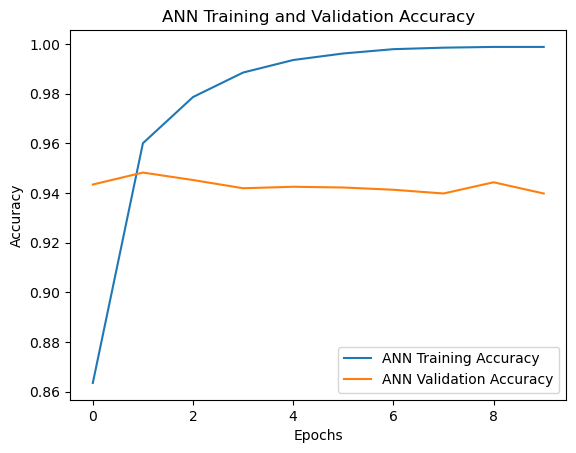

In [23]:
# Plot training and validation accuracy for ANN
plt.plot(ann_history.history['accuracy'], label='ANN Training Accuracy')
plt.plot(ann_history.history['val_accuracy'], label='ANN Validation Accuracy')
plt.title('ANN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

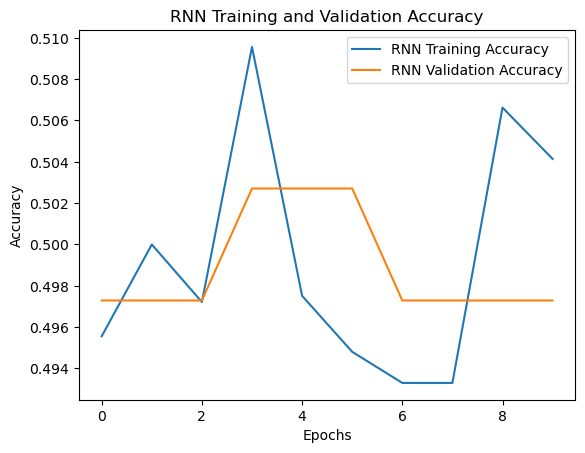

In [24]:
# Plot training and validation accuracy for RNN
plt.plot(rnn_history.history['accuracy'], label='RNN Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Validation Accuracy')
plt.title('RNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
# Confusion matrix for ANN
ann_Y_pred = (ann_model.predict(tfidf_X_test.toarray()) > 0.5).astype("int32")
ann_cm = confusion_matrix(Y_test, ann_Y_pred)

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


([<matplotlib.axis.YTick at 0x172d21e4ad0>,
 [Text(0, 0, 'FAKE'), Text(0, 1, 'REAL')])

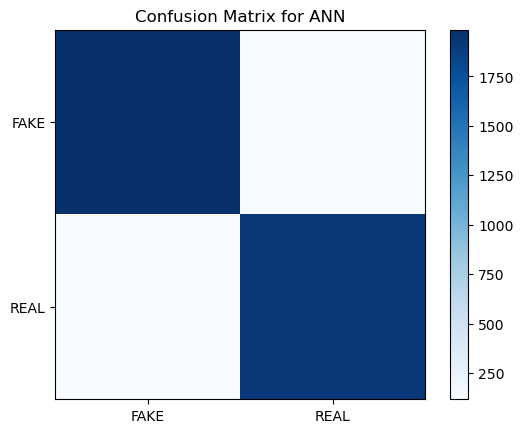

In [26]:
plt.figure()
plt.title('Confusion Matrix for ANN')
plt.imshow(ann_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['FAKE', 'REAL'])
plt.yticks(tick_marks, ['FAKE', 'REAL'])

In [27]:
import itertools

In [28]:
# Confusion matrix for RNN
rnn_Y_pred = (rnn_model.predict(tfidf_X_test.toarray()) > 0.5).astype("int32")
rnn_cm = confusion_matrix(Y_test, rnn_Y_pred)

130/130 ━━━━━━━━━━━━━━━━━━━━ 50s 382ms/step


([<matplotlib.axis.YTick at 0x172d11a5150>,
 [Text(0, 0, 'FAKE'), Text(0, 1, 'REAL')])

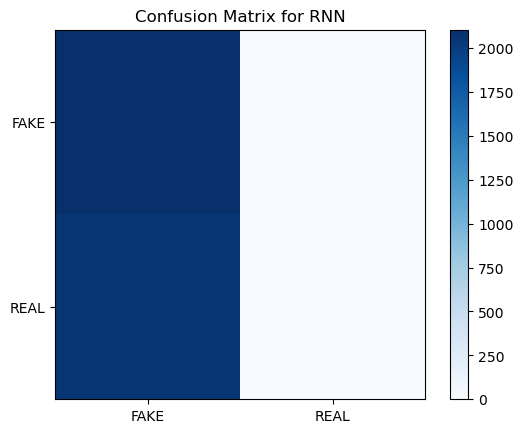

In [29]:
plt.figure()
plt.title('Confusion Matrix for RNN')
plt.imshow(rnn_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['FAKE', 'REAL'])
plt.yticks(tick_marks, ['FAKE', 'REAL'])


In [30]:
import re
import nltk
import pickle

# Function to preprocess text
def preprocess_text(text):
    lemmatizer = nltk.WordNetLemmatizer()
    stpwrds = set(nltk.corpus.stopwords.words('english'))
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert text to lowercase
    text = nltk.word_tokenize(text)  # Tokenize text
    text = [lemmatizer.lemmatize(word) for word in text if word not in stpwrds]  # Lemmatize words
    return ' '.join(text)

# Function to predict whether news is fake or real
def predict_fake_news(news):
    # Preprocess the input news article
    preprocessed_news = preprocess_text(news)
    
    # Load the TF-IDF vectorizer and the model
    with open('vector.pkl', 'rb') as f:
        tfidf_v = pickle.load(f)
    with open('model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    # Vectorize the preprocessed news article
    vectorized_news = tfidf_v.transform([preprocessed_news])
    
    # Predict the label (0 for fake, 1 for real)
    prediction = model.predict(vectorized_news)[0]
    
    if prediction == 1:
        return "Real News"
    else:
        return "Fake News"

# Example usage
news_article = "CSK win IPL in 2023."
prediction = predict_fake_news(news_article)
print("Prediction:", prediction)


Prediction: Real News


In [31]:
from nltk.translate.bleu_score import sentence_bleu

# Example function to calculate BLEU score
def calculate_bleu_score(reference, hypothesis):
    return sentence_bleu([reference], hypothesis)

# Example usage
reference_text ='''Yes There Are Paid Government Trolls On Social Media, Blogs, Forums And Websites February 26th, 2014'''
hypothesis_text = "Generated text from the model."
bleu_score = calculate_bleu_score(reference_text, hypothesis_text)

print("BLEU Score:", bleu_score)

BLEU Score: 1.0695028554759082e-155


C:\ProgramData\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\ProgramData\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [33]:
from nltk.translate.bleu_score import sentence_bleu

# Flatten the list of lists into a single list
hypothesis_flat = [token for sublist in ann_Y_pred.tolist() for token in sublist]

# Calculate BLEU score
bleu_score_rnn = sentence_bleu(reference_text, hypothesis_flat)

# Print the BLEU score
print("BLEU Score for RNN:", bleu_score_ann)


BLEU Score for RNN: 0


In [4]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91762\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# printing the stopwords in English
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
# Load data
train_df = pd.read_csv('train.csv')

In [8]:
train_df.shape

(20800, 5)

In [6]:
# print the first 5 rows of the dataframe
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [9]:
# counting the number of missing values in the dataset
train_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [10]:
# replacing the null values with empty string
train_df = train_df.fillna('')

In [11]:
# merging the author name and news title
train_df['content'] = train_df['author']+' '+train_df['title']

In [12]:
print(train_df['content'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object


In [14]:
# separating the data & label
X = train_df.drop(columns='label', axis=1)
Y = train_df['label']

In [15]:
print(X)
print(Y)

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

In [16]:
port_stem = PorterStemmer()

In [17]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [18]:
train_df['content'] = train_df['content'].apply(stemming)

In [19]:
print(train_df['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


In [20]:
#separating the data and label
X = train_df['content'].values
Y = train_df['label'].values

In [21]:
print(X)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']


In [22]:
print(Y)

[1 0 1 ... 0 1 1]


In [23]:
Y.shape

(20800,)

In [24]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

In [22]:
print(X)

  (0, 15686)	0.28485063562728646
  (0, 13473)	0.2565896679337957
  (0, 8909)	0.3635963806326075
  (0, 8630)	0.29212514087043684
  (0, 7692)	0.24785219520671603
  (0, 7005)	0.21874169089359144
  (0, 4973)	0.233316966909351
  (0, 3792)	0.2705332480845492
  (0, 3600)	0.3598939188262559
  (0, 2959)	0.2468450128533713
  (0, 2483)	0.3676519686797209
  (0, 267)	0.27010124977708766
  (1, 16799)	0.30071745655510157
  (1, 6816)	0.1904660198296849
  (1, 5503)	0.7143299355715573
  (1, 3568)	0.26373768806048464
  (1, 2813)	0.19094574062359204
  (1, 2223)	0.3827320386859759
  (1, 1894)	0.15521974226349364
  (1, 1497)	0.2939891562094648
  (2, 15611)	0.41544962664721613
  (2, 9620)	0.49351492943649944
  (2, 5968)	0.3474613386728292
  (2, 5389)	0.3866530551182615
  (2, 3103)	0.46097489583229645
  :	:
  (20797, 13122)	0.2482526352197606
  (20797, 12344)	0.27263457663336677
  (20797, 12138)	0.24778257724396507
  (20797, 10306)	0.08038079000566466
  (20797, 9588)	0.174553480255222
  (20797, 9518)	0.295420

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

In [26]:
model = LogisticRegression()

In [27]:
model.fit(X_train, Y_train)

LogisticRegression()

In [28]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [29]:
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.9865985576923076


In [30]:
# accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [31]:
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9790865384615385


In [37]:
# Preprocess the new text data
preprocessed_text = stemming("Russian Researchers Discover Secret Nazi Military Base â€˜Treasure Hunterâ€™ in the Arctic [Photos]")
# Transform the preprocessed text data into numerical features using the TF-IDF Vectorizer
numerical_features = vectorizer.transform([preprocessed_text])

# Use the trained Logistic Regression model to make predictions
prediction = model.predict(numerical_features)

# Print the prediction
print(prediction)
if (prediction[0]==0):
    print('The news is Real')
else:
    print('The news is Fake')

[1]
The news is Fake
